# Convolutional Neural Networks (CNN) and Deep Architectures

In these practicals, we will create a first convolutional neural network (CNN). This type of networks mostly rely on alternating layers of convolution and pooling. A convolution layer is a signal processing inspired layer that performs a bunch of convolutions on the layer input and yields filtered outputs known as feature maps. A pooling layer is a sort of subsampling layer. Most of the time, after several Conv/Pool layer pairs, a usual MLP is plugged to obtain class membership probabilities. When the number of layers is rather high (unclear how high this is), we obtain a deep network.

We will use `TensorFlow` as programming framework and build a CNN to solve an image classification task.

## Starting with TensorFlow

`TensorFlow` is Google's library designed to create and train deep nets. It relies on symbolic programming and on the notion of computation graph. Here is an example of such a graph:

<img src="graph.png" alt="drawing" width="200"/>

In this graph, we prepare `TensorFlow` to later compute the following function :

$$f\left( x,y\right) = x^2 + 2y,$$

for some $x$ and $y$. In this graph, the variables $x$ and $y$ are instances of the `tf.placeholder` class. Given these two objects, programming function $f$ is quite easy. We just need one line of code to explain `TensorFlow` how to compute $f\left( x,y\right)$ given $x$ and $y$:

```python
f = x*x + 2*y
```

This is done in a symbolic way meaning that $+$ here is not the usual Python + but `TensorFlow`'s addition operator. 

There are consequently two programming phases when using `TensorFlow`:
* graph building and variable declaration,
* actual computation performed as part of a `session`.

Here is the full code to build the graph for function $f$ followed by a `session` to compute function values for some $(x,y)$ pairs.

In [539]:
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")

In [540]:
x = tf.placeholder(tf.float32,shape=[])
y = tf.placeholder(tf.float32,shape=[])
f = x*x + 2*y
some_x = [1,2,3]
some_y = [2,3,4]
with tf.Session() as sess:
    for i in range(len(some_x)):
        print(sess.run(f,feed_dict={x: some_x[i],y: some_y[i]}))

5.0
10.0
17.0


The `tf.placeholder` class is meant to define variables that will be later replaced with data streams. Here, we specified that these data are `float32` and that they are scalars (`shape=[]`). In the `session`, we explain `TensorFlow` that the `x` and `y` will now be replaced by some specific values which we defined before as integer lists. 

### Question1 :
* Define in a symbolic way the gradient of function $f$ (see `TensorFlow.gradients` documentation) and compute the gradient vectors for the same $(x,y)$ pairs as in the above code. 


In [541]:
with tf.Session() as sess:
    for i in range(len(some_x)):
        print("The gradient of f on (x, y)={xy} :".format(xy=(some_x[i],some_y[i])),sess.run(tf.gradients(f, [x,y]),feed_dict={x: some_x[i],y: some_y[i]}))

The gradient of f on (x, y)=(1, 2) : [2.0, 2.0]
The gradient of f on (x, y)=(2, 3) : [4.0, 2.0]
The gradient of f on (x, y)=(3, 4) : [6.0, 2.0]


---

## Baseline CNN

We are now almost ready to start building a `TensorFlow` graph containing convolution or pooling layers instead of the basic operations involved in function $f$. Unlike function $f$, the classification function that we are trying to learn is parametric. Parameters can be explicitely defined as `TensorFlow` variables which are instances of the `tf.Variable` class. Since the backpropagation cannot work if parameters are not intialized, we will be using an initializer provided by `TensorFlow`. However, we will not explicitely define parameters but instead use `TensorFlow` macroscopic layerwise functions which encompass `TensorFlow` variables. This makes the code much simpler but less modular.

But first things first ! We need a dataset to work with and to load in Jupyter. We will be working with the `MNIST` dataset. This dataset contains 28x28 grayscale images of handwritten figures. It has the advantage to be larger than traditional datasets utilized in practicals while it can still hold in memory and converge in a few minutes. Larger or more complicated datasets (more variability in images) would require too many computational efforts.

Download the `MNIST` archive at [mnist.pkl.gz](http://deeplearning.net/data/mnist/mnist.pkl.gz). Load the dataset using the `load_mnist` function. You need to feed it with the path to the `MNIST` archive.

In [542]:
import numpy as np
import sys
from matplotlib.pyplot import imshow
import gzip
import _pickle as cPickle

def load_mnist(filename):
    f = gzip.open(filename, 'rb')
    train_set, valid_set, test_set = cPickle.load(f, encoding='iso-8859-1')
    f.close()
    X = np.vstack((train_set[0],valid_set[0]))
    y = np.hstack((train_set[1],valid_set[1]))
    X_test = test_set[0]
    y_test = test_set[1]
    return X,y,X_test,y_test

# load the MNIST archive
X,y,X_test,y_test = load_mnist("mnist.pkl.gz")

### Question2:
* Reshape `X` and `X_test` so that they have shape (60000,28,28,1) and (10000,28,28,1) respectively.


In [543]:
X = np.reshape(X, (60000,28,28,1))
X_test = np.reshape(X_test, (10000,28,28,1))

print("New shape of the X : ", X.shape)
print("New shape of the X_test : ", X_test.shape)

New shape of the X :  (60000, 28, 28, 1)
New shape of the X_test :  (10000, 28, 28, 1)


We can now begin to build the CNN. At the start of the `TensorFlow` graph we need to define data containers, i.e. instances of `tf.placeholder`. We will use mini-batch gradient descent to optimize the NN parameters and we want the code to be modular so we cannot specify the first dimension of the tensor containing training examples. `TensorFlow` allows this :

In [544]:
Xtf = tf.placeholder(tf.float32,shape=[None, X.shape[1], X.shape[2],1])
ytf = tf.placeholder(tf.int64,shape=[None, ])
Xtf.shape

TensorShape([Dimension(None), Dimension(28), Dimension(28), Dimension(1)])

The next element of our NN is a 2D convolutional layer. We can use an instance of the `tf.layers.conv2d` class. We need to specify that a `tf.placeholder` instance is the input, the number of size of filters (kernels) that we want, how to deal with image borders (padding) and what activation we would like. This gives:

In [545]:
# Convolutional Layer #1
conv1 = tf.layers.conv2d(
      inputs=Xtf,
      filters=64,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)
conv1.shape

TensorShape([Dimension(None), Dimension(28), Dimension(28), Dimension(64)])

Next, we need a pooling layer to give up some entries of the filtered images provided by the convolutional layer. We will use the usual **max pool function** in 2x2 neighborhoods which drops 3 entries out of 4 in each such neighborhood. The remaining entry is the one achieving maximal value in the neighborhood.

### Question3 :
* What is the role of parameter `strides` ? 
* What is the size of each feature map after max pooling ?
* How many feature maps are there ? 

#### <font color='blue'> 3.1) What is the role of parameter strides ?

In [546]:
# Pooling Layer #1
pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

* <font color="#80000"> The parameter "strides" represents the step size, which is used in the **sub-sampling layers** operation used to unroll the input set.

#### <font color='blue'>3.2) What is the size of each feature map after max pooling ?

In [547]:
nbr_samples,heigth,width,nbr_filters=pool1.shape
print("The dimensions of the feature map after max-polling are : heigth = {heigth} and width = {width}".format(heigth=heigth, width=width))

The dimensions of the feature map after max-polling are : heigth = 14 and width = 14


#### <font color='blue'>3.3) How many feature maps are there ?

* <font color="#80000"> The number of feature maps is exactly the number of filters we used in the convolution, since the pooling is done on each feature map and does thus does not affect the number of feature which is $64$.

### Before getting to the second part, let have a look at the effect of the convolution and the sub-sampling on a test image :

In [548]:
# upload a test image
testImage=X_test[1]
test = tf.Session()
test.run(tf.global_variables_initializer())
testImageAfterConv1 = test.run(conv1, feed_dict={Xtf: np.reshape(testImage, (1,28,28,1))})
testImageAfterPool1 = test.run(pool1, feed_dict={Xtf: np.reshape(testImage, (1,28,28,1))})

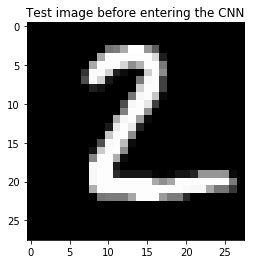

In [549]:
# test image on its input format
plt.imshow(testImage.reshape(28,28),cmap='gray')
plt.title("Test image before entering the CNN")
plt.show()

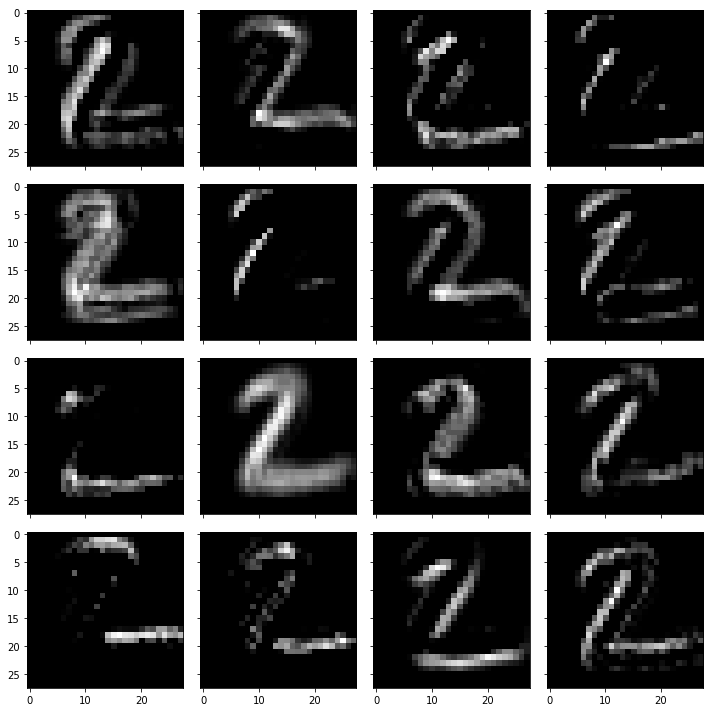

In [550]:
from displayImages import display2dImages
# Some feature maps after applying the first convolution to the test image
display2dImages(imagesSet=testImageAfterConv1,tupleImages=(4,4), figsize=(10,10))

* <font color="#80000"> With the first convolution, we already see that some feature paterns are extracted. We can not assume the interest of some patterns directely, but we can notice that some feature maps point to some particular patterns, like the edges of the digit and in general its shape.  

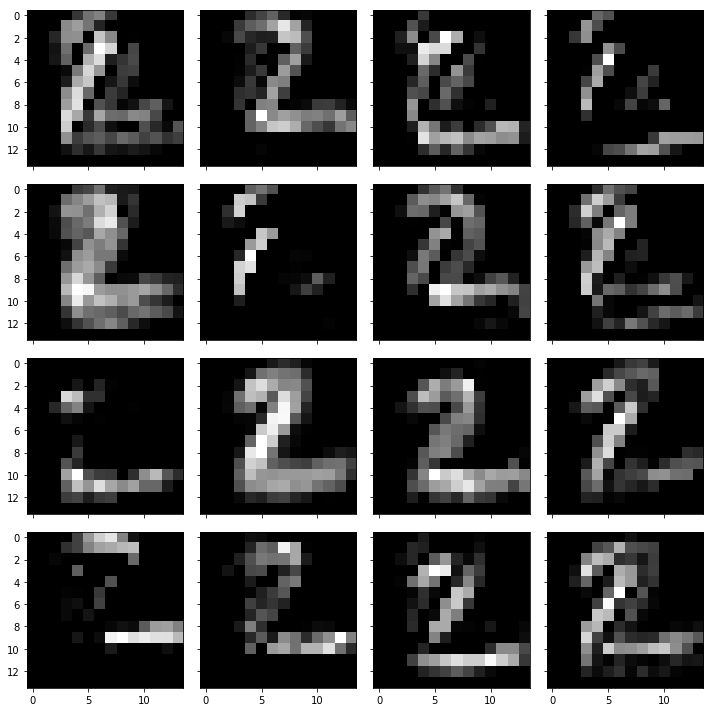

In [551]:
from displayImages import display2dImages
# Some feature maps after applying the pooling to the first convolution feature maps
display2dImages(imagesSet=testImageAfterPool1,tupleImages=(4,4), figsize=(10,10))

* <font color="#80000"> We can notice that the pooling conserves the general effect of the convolution feature maps and produces more general features and so patterns. Thus, the pooling avoids the the eventual overfitting of the neural network by picking more generic features from the results of the convolution step. This makes one of the reasons the CNNs are too powerfull till they inherently taking into consideration the tradeoff between minimizing the training error and minimizing the expected gap between the training error and the test error, by applying a kind of structural regularization of the neural network. (This tradeoff is well explained in the scientific paper : **Gradient Based Learning Applied To Document Recognition by Yann LeCun** "https://ieeexplore.ieee.org/abstract/document/726791")  


#### We will now plug a 1 layer MLP on top of this. Fully connected layers (or dense layers) do not accept `numpy ndarrays`. We can use `tf.reshape` to flatten feature maps. In the following code the scalar `dflat` = nbr of feature maps x feature map width x feature map height. Set this variable with the correct value and execute the following code line:

In [552]:
# flatten the feature maps 
dflat = nbr_filters*width*heigth
pool2_flat = tf.reshape(pool1, [-1, dflat])
pool2_flat.shape

TensorShape([Dimension(None), Dimension(12544)])

Now the one layer MLP is given by an instance of `tf.layers.dense` as:

In [553]:
mlp = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)

Finally, we need a softmax regression function to obtain class membership probabilities. This can be done in this way:

In [554]:
logits = tf.layers.dense(inputs=mlp, units=10)
smax = tf.nn.softmax(logits)

### Question4 :
* How many parameters is there in our NN ?

<font color="#80000"> So far there are 5 parameters for the the NN if we consider the pooled model as one parameter (The input). The other parameters are :
* Units
* Activation function for the MLP
* The regression function at the output layer
* The loss function (defined below)
    
For the input (pooled model) we have the following 8 parameters :
* The learning rate
* Number of strides
* The pool size parameter 
* The batch size
* Number of filters
* Filter sizes
* Activiation functions
* Padding types

**This makes the CNN too much modular given a lot of parameters which might imply a lot of time for the tuning**

Actually, the utimate element of the `TensorFlow` graph is the loss. In softmax (or logistic) regression, the corresponding loss is the cross entropy. A numerically stable version of this loss is given by `tf.losses.sparse_softmax_cross_entropy`:

In [555]:
loss = tf.losses.sparse_softmax_cross_entropy(labels=ytf, logits=logits)

Now that we have completed the graph, we can move to the next phase: actually training the NN. Prior to entering the training loop, we need to instantiate an optimizer from `TensorFlow` and ask him to minimize the loss. We will use the ADAM optimizer which is robust and easy to tune.

In [556]:
learning_rate = 0.01
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

An initializer has also been instantiated. Indeed parameters are hidden in instances of our NN layers but they need initialization anyway.

We can now begin to iterate on training examples. We will select mini-batches of training examples. Once each training example has been processed as part of the backpropagation algorithm, a training epoch is completed. It is quite common to iterate on epochs, and in each epoch on mini-batches. 

The following code lines are in line with this habit. There are only two lines to complete to make it work. They correpond to the selection of training examples in each mini-batch. 

### Question5 :
* Fulfill correctly the missing parts of these instructions.
**Warning** : the execution of the loop takes around 5mn. The gradient descent should achieve approximately a 0.13 loss or below (remember this is stochastic).

In [66]:
n=y.shape[0]
n_epochs = 2
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = n // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch = X[iteration*batch_size:(iteration+1)*batch_size] # Specifying the input batch 
            y_batch = y[iteration*batch_size:(iteration+1)*batch_size] # Specifying the target batch
            sess.run(training_op, feed_dict={Xtf: X_batch,ytf: y_batch})
        loss_train = loss.eval(feed_dict={Xtf: X_batch,ytf: y_batch})
        print("\r{}".format(epoch), "Train loss:", loss_train)

0 Train loss: 0.1097685
1 Train loss: 0.11454113


### Question6 :
* Document yourselves on means to compute the classifier accuracy using `TensorFlow` functions. 
* Add the corresponding functions to the graph.
* Modify the loop to evaluate the classifier accuracy on the test set. 
* Comment on the quality of the learning.

<font color="#80000"> **Documentation results :**  We found various ways to compute the accuracy with tensorflow. One way (the one we use below) is to first add the **argmax** function to the graph till the output of the CNN are probabilities of the input being equal to a given digit in $\{0,1,...,9\}$. Therefore this function role is to return the digit with the highest probability. Later we add the accuracy metrique of tensorflow, which, given the labels and the predictions computes the accuracy.

In [557]:
# adding the argmax function to the graph
argma=tf.argmax(input=smax,axis=1)

In [558]:
# adding the accuracy function to the graph
accuracy=tf.metrics.accuracy(labels=ytf, predictions=argma)

init = tf.global_variables_initializer()
init_l = tf.local_variables_initializer()

In [172]:
# The modified training and testing process, which includes the accuracy's computation for each epoch
n=y.shape[0]
n_epochs = 2
batch_size = 150

with tf.Session() as sess:
    init.run()
    init_l.run()
    for epoch in range(n_epochs):
        n_batches = n // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch = X[iteration*batch_size:(iteration+1)*batch_size] # Specifying the input batch 
            y_batch = y[iteration*batch_size:(iteration+1)*batch_size] # Specifying the target batch
            sess.run(training_op, feed_dict={Xtf: X_batch,ytf: y_batch})
        loss_train = loss.eval(feed_dict={Xtf: X_batch,ytf: y_batch})
        feed_dict_test = {Xtf: X_test, ytf:y_test}
        model_accuracy=sess.run(accuracy, feed_dict_test)
        print("\r{}".format(epoch+1), "Train loss:", loss_train)
        print("The accuracy of the model for epoch number {ep} is : {ac} %\n".format(ep=epoch+1,ac=model_accuracy[1]*100))

1 Train loss: 0.114613205
The accuracy of the model this epoch is : 96.56000137329102 %

2 Train loss: 0.09727109
The accuracy of the model this epoch is : 97.18999862670898 %



<font color="#80000"> **Comments :** We clearly have obtained a high accuracy level (~97 %) on the test set. This confirms the Convolution Neural Networks powerfull approach in pattern recognition applied to digits. We might like to use the cross validation to confirm the stability of the generalization error, but the computation takes too long. With the same set of hyperparameters, we just launched the process three times with different test sets and verified that this accuracy is stable and does slightly change (if drastically : 0.5 %)  around 97% .    

### Question7 :
* Add a second pair of conv/pool layers. A smaller amount of filters and smaller filters are recommended.

In [606]:
# Convolutional Layer #2
nbr_filters=20
conv2 = tf.layers.conv2d(
      inputs=pool1,
      filters=nbr_filters,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)
conv2.shape

TensorShape([Dimension(None), Dimension(14), Dimension(14), Dimension(20)])

In [607]:
# Pooling Layer #2
pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
nbr_samples_2,heigth_2,width_2,nbr_filters_2=pool2.shape

In [608]:
# flatten the feature maps 
dflat_2 = nbr_filters_2*width_2*heigth_2
pool2_flat_2 = tf.reshape(pool2, [-1, dflat_2])
pool2_flat_2.shape

TensorShape([Dimension(None), Dimension(980)])

### Question8 :
* Add a second fully connected layer. A smaller number of units is recommended.

In [609]:
# Add the first fully connected NN (already used above)
nbUnitsMlp1=1024
mlp = tf.layers.dense(inputs=pool2_flat_2, units=nbUnitsMlp1, activation=tf.nn.relu)
mlp.shape

TensorShape([Dimension(None), Dimension(1024)])

In [610]:
# Adding the second fully connected NN with less number of units 500
nbUnitsMlp2=500
mlp_2 = tf.layers.dense(inputs=mlp, units = nbUnitsMlp2, activation=tf.nn.relu)
mlp_2.shape

TensorShape([Dimension(None), Dimension(500)])

In [611]:
# set softmax regression function
logits_2 = tf.layers.dense(inputs=mlp_2, units=10)
smax_2 = tf.nn.softmax(logits_2)

In [612]:
# Redefine the loss for the new CNN
loss_2 = tf.losses.sparse_softmax_cross_entropy(labels=ytf, logits=logits_2)

In [613]:
# Set the training process (minimizer of the loss)
learning_rate = 0.01
optimizer_2 = tf.train.AdamOptimizer(learning_rate)
training_op_2 = optimizer.minimize(loss_2)

In [614]:
# Reset the accuracy for the new CNN
argma_2=tf.argmax(input=smax_2,axis=1)

accuracy_2=tf.metrics.accuracy(labels=ytf, predictions=argma_2)

init_2 = tf.global_variables_initializer()
init_3 = tf.local_variables_initializer()

### Question9 :
From the above NN architecture, try to tweak the other hyperparameters. These latter include:
* the learning rate,
* the mini batch size,
* the regularization strength (if regularization is activated),
* number of filters,
* filter sizes,
* activiation functions,
* strides,
* padding types,
* ...

<font color="#80000"> **Given the computation time of the model, we studied three hyperparameters : The learning rate, the batch size and the activation functions, using small number of epochs, till we only want to know the general trending of the model's performance when we change those hyperparameters.**

In [600]:
n=y.shape[0]
n_epochs = 1
batch_size = 150

with tf.Session() as sess:
    init_2.run()
    init_3.run()
    for epoch in range(n_epochs):
        n_batches = n // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch = X[iteration*batch_size:(iteration+1)*batch_size] # Specifying the input batch 
            y_batch = y[iteration*batch_size:(iteration+1)*batch_size] # Specifying the target batch
            sess.run(training_op_2, feed_dict={Xtf: X_batch,ytf: y_batch})
        loss_train_2 = loss_2.eval(feed_dict={Xtf: X_batch,ytf: y_batch})
        feed_dict_test_2 = {Xtf: X_test, ytf:y_test}
        model_accuracy_2=sess.run(accuracy_2, feed_dict_test_2)
        print("\r{}".format(epoch+1), "Train loss:", loss_train)
        print("The accuracy of the model for epoch number {ep} is : {ac} %\n".format(ep=epoch+1,ac=model_accuracy_2[1]*100))

1 Train loss: 0.10081227
The accuracy of the model for epoch number 1 is : 97.58999943733215 %



<font color="#80000"> **Comments :** Having added others layers of convolution, pooling and two NN fully connected layers instead of one, we see that the test error (approximating the generalization error) has slightely changed. We can not assume  that the generalization error is also the same, beacuse we need to make a cross validation to do so, but we can postulate that this new model needs more regularization that the first one to avoid the eventual overfitting given the fully connected neural networks we introduced before the output layer. 

In [615]:
# We define below a generic function to compute the train loss and the accuracy
def LossAndAccuracy(training_op=training_op_2,logits=logits_2, loss=loss_2, batch_size=150, accuracy=accuracy_2):
    with tf.Session() as sess:
        tf.global_variables_initializer().run()
        tf.local_variables_initializer().run()
        n_batches = n // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch = X[iteration*batch_size:(iteration+1)*batch_size] # Specifying the input batch 
            y_batch = y[iteration*batch_size:(iteration+1)*batch_size] # Specifying the target batch
            sess.run(training_op, feed_dict={Xtf: X_batch,ytf: y_batch})
        loss_train_2 = loss.eval(feed_dict={Xtf: X_batch,ytf: y_batch})
        feed_dict_test_2 = {Xtf: X_test, ytf:y_test}
        model_accuracy_2=sess.run(accuracy, feed_dict_test_2)
        return loss_train_2, model_accuracy_2[1]

* ### (1) the learning rate :

In [602]:
learningRates=[1,0.1,0.001]
CnnAccuracies1, loss_trains1=[],[]
for rate in learningRates:
    optimizer = tf.train.AdamOptimizer(rate)
    training_op = optimizer.minimize(loss_2)
    lossEr, Accur = LossAndAccuracy(training_op)
    loss_trains1.append(lossEr)
    CnnAccuracies1.append(Accur)

99%

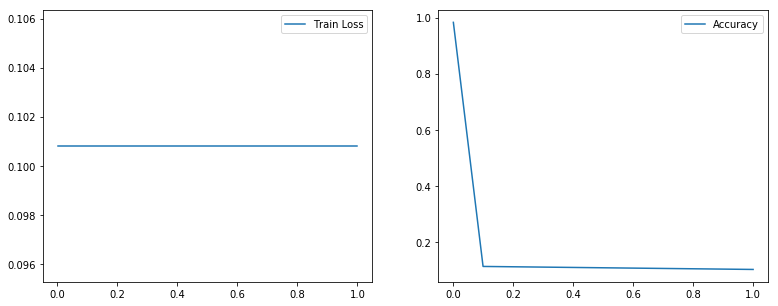

In [603]:
plt.figure(figsize=(13,5))
plt.title("Accuracy and Train Loss varaition with the learning rate")
plt.xlabel("Learning rate")
plt.subplot(121)
plt.plot(learningRates, loss_trains1, label="Train Loss")
plt.legend()
plt.subplot(122)
plt.plot(learningRates, CnnAccuracies1, label="Accuracy")
plt.legend()
plt.show()

<font color="#80000"> **Comments :** We clearly see that the learning rate affects dramaticcaly the learning. For bigger values, the model gives a very bad accuracy. Therfore, the smaller the learning rate the better is the accuracy of the model. We even obtain a better accuracy with learning rate of $0.001$ we obtain an accuracy of ~$98\%$ which is better than our first model's accuracy.

* ### (2) the batch size :

In [616]:
batch_sizes=[50,500,1000]
CnnAccuracies2, loss_trains2=[],[]
for batch in batch_sizes:
    lossEr, Accur = LossAndAccuracy(batch_size=batch)
    loss_trains2.append(lossEr)
    CnnAccuracies2.append(Accur)

98%

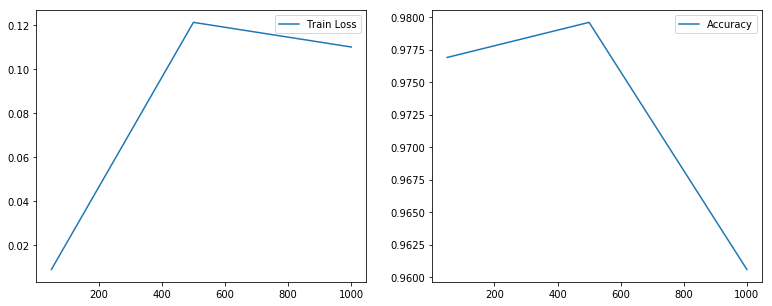

In [620]:
plt.figure(figsize=(13,5))
plt.title("Accuracy and Train Loss varaition with the learning rate")
plt.xlabel("Learning rate")
plt.subplot(121)
plt.plot(batch_sizes, loss_trains2, label="Train Loss")
plt.legend()
plt.subplot(122)
plt.plot(batch_sizes, CnnAccuracies2, label="Accuracy")
plt.legend()
plt.show()

<font color="#80000"> **Comments :** We see that the accuracy raised slightely when we compare a bach size of 50 to 500 ($97.69\%$ to $97.96\%$) but decreased to $96.06\%$ with 1000 as a bach size. Therefore, we might postulate that there is an optimal value for the bach size that raises slightely the performance of the CNN.

* ### (3) Activation function :

In [626]:
activiation_funcs=[tf.sigmoid, tf.nn.selu, tf.tanh]

CnnAccuracies3, loss_trains3=[],[]
for act in activiation_funcs:
    # Add the first fully connected NN (already used above)
    nbUnitsMlp1=1024
    mlp_act = tf.layers.dense(inputs=pool2_flat_2, units=nbUnitsMlp1, activation=act)
    # Adding the second fully connected NN with less number of units 100
    nbUnitsMlp2=500
    mlp_2_act = tf.layers.dense(inputs=mlp_act, units = nbUnitsMlp2, activation=act)
    # set softmax regression function
    logits_act = tf.layers.dense(inputs=mlp_2_act, units=10)
    smax_act = tf.nn.softmax(logits_act)
    # Redefine the loss for the new CNN
    loss_act = tf.losses.sparse_softmax_cross_entropy(labels=ytf, logits=logits_act)
    # Set the training process (minimizer of the loss)
    learning_rate = 0.01
    optimizer_act = tf.train.AdamOptimizer(learning_rate)
    training_op_act = optimizer.minimize(loss_act)
    # Reset the accuracy for the new CNN
    argma_act=tf.argmax(input=smax_act,axis=1)

    accuracy_act=tf.metrics.accuracy(labels=ytf, predictions=argma_act)

    init_act1 = tf.global_variables_initializer()
    init_act2 = tf.local_variables_initializer()
    
    n=y.shape[0]
    n_epochs = 1
    batch_size = 150

    with tf.Session() as sess:
        init_act1.run()
        init_act2.run()
        for epoch in range(n_epochs):
            n_batches = n // batch_size
            for iteration in range(n_batches):
                print("\r{}%".format(100 * iteration // n_batches), end="")
                sys.stdout.flush()
                X_batch = X[iteration*batch_size:(iteration+1)*batch_size] # Specifying the input batch 
                y_batch = y[iteration*batch_size:(iteration+1)*batch_size] # Specifying the target batch
                sess.run(training_op_act, feed_dict={Xtf: X_batch,ytf: y_batch})
            loss_train_act = loss_act.eval(feed_dict={Xtf: X_batch,ytf: y_batch})
            feed_dict_test_act = {Xtf: X_test, ytf:y_test}
            model_accuracy_act=sess.run(accuracy_act, feed_dict_test_act)
            CnnAccuracies3.append(model_accuracy_act[1])
            loss_trains3.append(loss_train_act)

99%

In [627]:
activfuncs=["sigmoid", "selu", "tanh"]
for i in range(3):
    print("The accuracy unsing the \"{fct}\" activation function is : {accu}%".format(fct=activfuncs[i],accu=CnnAccuracies3[i]*100))
    print("The train loss is : {}% \n".format(loss_trains3[i]))

The accuracy unsing the "sigmoid" activation function is : 97.4399983882904%
The train loss is : 0.10328179597854614% 

The accuracy unsing the "selu" activation function is : 98.29999804496765%
The train loss is : 0.14770980179309845% 

The accuracy unsing the "tanh" activation function is : 98.43999743461609%
The train loss is : 0.14926908910274506% 



<font color="#80000"> **Comments :** We have obtained defenet values of accuracies for each activation function that are slightly close between each other and to the **relu** we already used. Having used one epoch we can not draw final conclusions, but we already see that they all give good results with **tanh** having the best performance for this particular simulation. Thus, the choice of the activation function is not of o very direct effect on the performance of the CNN, but we still may need to tune this parameter too for higher number of layers. 

### Question10 :
* Compare the obtained accuracy to that of a regularized Softmax regression from `sklearn`.

In [235]:
# data sets preparation
inter=np.arange(len(y))
np.random.shuffle(inter) #shuffle the data set to 
train, test = np.split(inter, [int(0.67 * n)])

X_log=np.reshape(X, (X.shape[0],-1))
X_train, X_test=X_log[train], X_log[test]
y_train, y_test=y[train], y[test]

In [236]:
from sklearn.linear_model import LogisticRegression

train, test = np.split(X, [int(0.67 * n)])

solvers=["newton-cg", "sag", "saga", "lbfgs"]
# training of softmax regression and test of performances
for solver in solvers :
    softmax_model = LogisticRegression(penalty="l2", solver=solver, max_iter=100, multi_class='multinomial')
    acc=(softmax_model.fit(X_train, y_train).score(X_test, y_test))*100
    print("The accuracy of the Softmax regression when using \"{}\" as a solver is : ".format(solver)+str(acc)+" %")

The accuracy of the Softmax regression when using "newton-cg" as a solver is : 91.82323232323232 %
The accuracy of the Softmax regression when using "sag" as a solver is : 91.86363636363636 %
The accuracy of the Softmax regression when using "saga" as a solver is : 91.98484848484848 %
The accuracy of the Softmax regression when using "lbfgs" as a solver is : 91.88383838383838 %


<font color="#80000"> **Comments on the results :** 
* Having used regularized Softmax regression we do not **even** attain the accuracies of a **none tuned** CNN model (~92% for the best Softmax regression compared to ~97% accuracy for a simple none tuned CNN).
* Even with different optimization solvers, we the Softmax regression still away from the accuracy of a simple CNN. 
    

## Conclusion :
Convolutional Neural Networks represents one of the powerfull paradigm that gave back a scientific and practical interest for the use of neural networks in pattern recognition tasks. Something we saw throughout this work, since a basic architecture of this type of NN outperformed classical Machine Learning algorithms like the Logistic regression. 
This being said, there is still a lot of settings work to find the best models, which implies a lot of computation and storage capacity given the large modulation spectre of CNNs and NNs in general..